### IMPORTS

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### SETTING THE DATASET PATH

In [2]:
## TYPES OF PRE-PROCESSED DS AVAILABLE:
D1_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D1/"
D1_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D2/"
D2_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D2/"
D1_AREA_GAUSIAN_227px = "D://227px_AI_GB_D1/"
D1_AREA_GAUSIAN_250px = "D://250px_AI_GB_D1/"

D1_D2_MIXED_250px = "D://D1_D2_MIXED_250px/"
## ^ DATASET.NO_INTERPOLATION_BLUR-FILTER_IMG-SIZE ^

#SELECTING DATASET

ds_type = D1_D2_MIXED_250px
input_size = 250
input_dim = 3

#SETTING THE PATH
dataset_path = signature_types = os.listdir(ds_type)
# print(signature_types)

In [3]:
print("Types of signatures: ", len(dataset_path))

Types of signatures:  2


In [4]:
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
print(signs)

[('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0102014_01.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0102014_02.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0102014_03.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0102014_04.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0103004_02.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0103004_03.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0103004_04.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0104014_01.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0104014_02.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0104014_03.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0104014_04.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0105004_01.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0105004_02.png.png'), ('forgeries', 'D://D1_D2_MIXED_250px//forgeries/0105004_03.png.png'), ('forgeries', 'D://

In [5]:
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
print(signs_df.head())

   sign type                                              image
0  forgeries  D://D1_D2_MIXED_250px//forgeries/0102014_01.pn...
1  forgeries  D://D1_D2_MIXED_250px//forgeries/0102014_02.pn...
2  forgeries  D://D1_D2_MIXED_250px//forgeries/0102014_03.pn...
3  forgeries  D://D1_D2_MIXED_250px//forgeries/0102014_04.pn...
4  forgeries  D://D1_D2_MIXED_250px//forgeries/0103004_02.pn...


In [6]:
print("Total number of signs in the dataset: ", len(signs_df))

Total number of signs in the dataset:  4261


In [7]:
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
genuine      2207
forgeries    2054
Name: sign type, dtype: int64


### CREATING LIST ARRAY OF IMAGES WITH LABELS

In [8]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing genuine: 100%|██████████| 2207/2207 [00:04<00:00, 469.94it/s]


### PLOTTING IMG BEFORE & AFTER PRE-PROCESSING

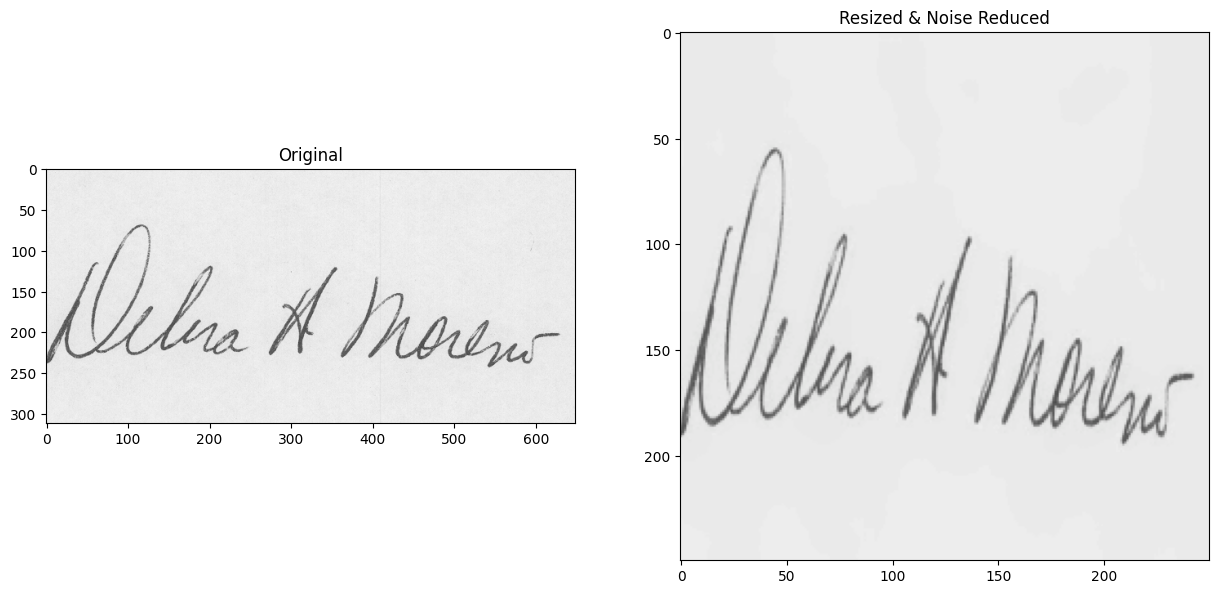

In [9]:
img_og = cv2.imread("D://cedar_original//full_org/original_9_9.png")
img_pp = cv2.imread('D://250px_AI_GB_D1//genuine/original_9_9.png.png')
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
_counter = 0
for idx, img in enumerate([img_og, img_pp]):
    ax[idx].imshow(img.astype(int))
    if _counter == 0:
        ax[idx].set_title("Original")
        _counter += 1
    else:
        ax[idx].set_title("Resized & Noise Reduced")

In [10]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [11]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
# print(Y.shape)

### SPLITTING THE DATASET (80 : 20)

In [12]:
images, Y = shuffle(images,Y,random_state=1)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.3, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)
train_x = train_x / 255.0
test_x = test_x / 255.0

(2982, 250, 250, 3)
(1279, 250, 250, 3)
(2982, 2)
(1279, 2)


### PROPOSED CNN MODEL (based on ijerph)

In [13]:
## This CNN does not work with image size < 240px
cnn = models.Sequential([
     layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu', input_shape=(input_size, input_size, input_dim)),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu'),
     # layers.MaxPooling2D((2, 2)),
     # layers.BatchNormalization(),
     layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     # layers.MaxPooling2D((2, 2)),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.GlobalAveragePooling2D(),
     layers.BatchNormalization(),
     layers.Dense(128, activation= 'sigmoid'),
     layers.BatchNormalization(),
     layers.Flatten(),
     layers.Dropout(0.1),
     layers.Dense(2, activation= 'softmax')
     ])

### PROPOSED CNN MODEL (based on GWO)

In [14]:
# cnn = models.Sequential([
#   layers.Conv2D(filters=55, kernel_size=(3, 3), activation= 'relu', input_shape=(input_size, input_size, input_dim)),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=130, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=155, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Flatten(),
#   layers.Dense(2, activation = 'softmax')
#   ])

In [15]:
opti = tf.keras.optimizers.SGD(learning_rate=0.001)
cnn.compile(optimizer=opti,loss='BinaryCrossentropy',metrics=['accuracy'])
# cnn.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])
# cnn.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['accuracy'])
history = cnn.fit(train_x, train_y,  epochs = 30, validation_split=0.2, batch_size=30)

Epoch 1/30
80/80 [==============================] - 10s 81ms/step - loss: 0.2666 - accuracy: 0.8960 - val_loss: 0.7290 - val_accuracy: 0.4523
Epoch 2/30
80/80 [==============================] - 5s 62ms/step - loss: 0.1638 - accuracy: 0.9434 - val_loss: 0.7256 - val_accuracy: 0.4523
Epoch 3/30
80/80 [==============================] - 5s 61ms/step - loss: 0.1396 - accuracy: 0.9526 - val_loss: 0.7775 - val_accuracy: 0.5477
Epoch 4/30
80/80 [==============================] - 5s 61ms/step - loss: 0.1369 - accuracy: 0.9518 - val_loss: 0.8729 - val_accuracy: 0.5477
Epoch 5/30
80/80 [==============================] - 5s 62ms/step - loss: 0.1242 - accuracy: 0.9577 - val_loss: 1.0097 - val_accuracy: 0.5477
Epoch 6/30
80/80 [==============================] - 5s 62ms/step - loss: 0.1239 - accuracy: 0.9535 - val_loss: 1.0304 - val_accuracy: 0.5477
Epoch 7/30
80/80 [==============================] - 5s 62ms/step - loss: 0.1113 - accuracy: 0.9627 - val_loss: 1.3870 - val_accuracy: 0.5477
Epoch 8/30
8

### PLOTTING training_acc & testing_acc at each epoch

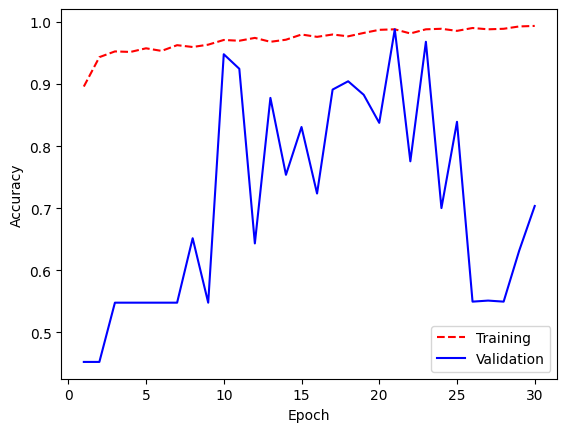

In [16]:
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
epoch_count = range(1, len(training_acc) + 1)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, validation_acc, 'b-')
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [17]:
testing = cnn.evaluate(test_x, test_y)
predictions = cnn.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(len(pred_y))
print(test_y)
print(classification_report(test_y,pred_y))

40/40 [==============================] - 1s 18ms/step
1279
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       1.00      0.31      0.47       632
           1       0.60      1.00      0.75       647

    accuracy                           0.66      1279
   macro avg       0.80      0.65      0.61      1279
weighted avg       0.80      0.66      0.61      1279



In [18]:
print(classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47       632
           1       0.60      1.00      0.75       647

    accuracy                           0.66      1279
   macro avg       0.80      0.65      0.61      1279
weighted avg       0.80      0.66      0.61      1279



In [19]:
print(len(pred_y))
print(len(test_y))

1279
1279


In [20]:
cm = confusion_matrix(test_y, pred_y)
print(cm)

[[193 439]
 [  0 647]]
